## EXPERIMENT 1: AdaFace

In [2]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white") 
%matplotlib inline
sys.path.append('../../utils') 
from MagFace_utils.MagFace_funcs import *
from Data_proc_utils.Data_proc_funcs import *

### AdaFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

### Load data

In [3]:
# Get all features from feature lists from magface model
feature_list_children = '../../master_thesis/saved_predictions/similarity_scores_children_full_baseline1.pt'
feature_list_adults = '../../master_thesis/saved_predictions/similarity_scores_adults_full_baseline1.pt'

image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors(feature_list_adults)
ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)

# Dataframes with info, removes names not in adaface results
children_all = pd.read_csv('../../data/YLFW_full_info_excluding_adults.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]
adults_all = pd.read_csv('../../data/RFW_full_info_excluding_children.csv')
adults_all = adults_all[adults_all.image_name.isin(image_names_a)] # OBS, this operation because some adaface images has not been through all adults images. 





### GET METRICS 10 TIMES

In [5]:
random_states = [42]#[1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_adaface_ex1_1 = {}
FNIR_c_list=[]
FNIR_a_list=[]
FPIR_c_list=[]
FPIR_a_list=[]
FPD_list=[]
FND_list=[]
GARBE_list=[]

for random_state_i in random_states:
    
    ### Load children and adults balanced data ###
    children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
    adults_balanced_df_i = balance_adults_data_enrolled(children_balanced_df_i, adults_all, print_stats=False, random_state=random_state_i)
    

    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)

    ### All reference image names, enrolled and non-enrolled image names - adults ###
    a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
    non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
    all_reference_image_names_a = list(adults_balanced_df_i.image_name)
  
    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a]
    
    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]
    sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]
    
    # Extract corresponding rows from the numerical ids    
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_a_reference = num_ids_a[indices_a_all_reference]

  
    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids 
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a]


    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_a_non_enrolled = sim_mat_a_reference_cols[indices_a_non_enrolled]

    # Extract corresponding rows from the numerical ids    
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]
    
    
    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids 
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_a_enrolled = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

    # Extract corresponding rows from the numerical ids    
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_a_enrolled = num_ids_a[indices_a_enrolled]
    

    ### DET THINGS ###
    thold = 0.50
    
    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)    
    FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)  
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_a = compute_fpir(sim_mat_a_non_enrolled, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)
    
    
    # OBS maybe compute Garbe outside funtion to choose a good alpha?
    alpha_garbe = 0.5
    FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)
    
    FNIR_c_list.append(FNIR_c)
    FNIR_a_list.append(FNIR_a)
    FPIR_c_list.append(FPIR_c)
    FPIR_a_list.append(FPIR_a)
    FPD_list.append(FPD_i)
    FND_list.append(FND_i)
    GARBE_list.append(GARBE_i)
    
    sim_mat_dict_all_adaface_ex1_1['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_adaface_ex1_1['sim_mat_a_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_a_enrolled
    sim_mat_dict_all_adaface_ex1_1['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled)
    sim_mat_dict_all_adaface_ex1_1['sim_mat_a_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_a_non_enrolled)
    
    
    print("done")

# Create a DataFrame from the lists
data = {'Iteration': random_states,'FNIR_c': FNIR_c_list, 'FNIR_a': FNIR_a_list, "FPIR_c": FPIR_c_list, "FPIR_a": FPIR_a_list, "FPD": FPD_list, "FND": FND_list, "GARBE": GARBE_list, "Threshold": thold} 
df_all_results = pd.DataFrame(data)




FPD result:  0.6339754816112083
FND result:  0.4494127136159701
GARBE result, GARBE close to 1 means more unfair:  0.5416940976135892
done


In [6]:
df_all_results

,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,42,0.376569,0.837914,0.418981,0.66088,0.633975,0.449413,0.541694,0.5


##### From DET utils - check import

In [7]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [8]:
mated_scores1 = sim_mat_a_enrolled
nonmated_scores1 = remove_ones(sim_mat_a_non_enrolled)
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,4564.000000,2.286144e+06
1,Minimum,-0.038128,-3.455990e-01
2,Maximum,0.949310,7.516636e-01
3,Mean,0.424998,1.889920e-01
4,St. Dev.,0.157886,1.136399e-01
5,Skewness,-0.049197,1.001368e-01
6,Ex. Kurtosis,-0.159403,1.159979e-02


In [9]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [10]:
def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)
    plt.figure(figsize=figure_size)
    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
        xlabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
        xlabel = "Count"
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(xlabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

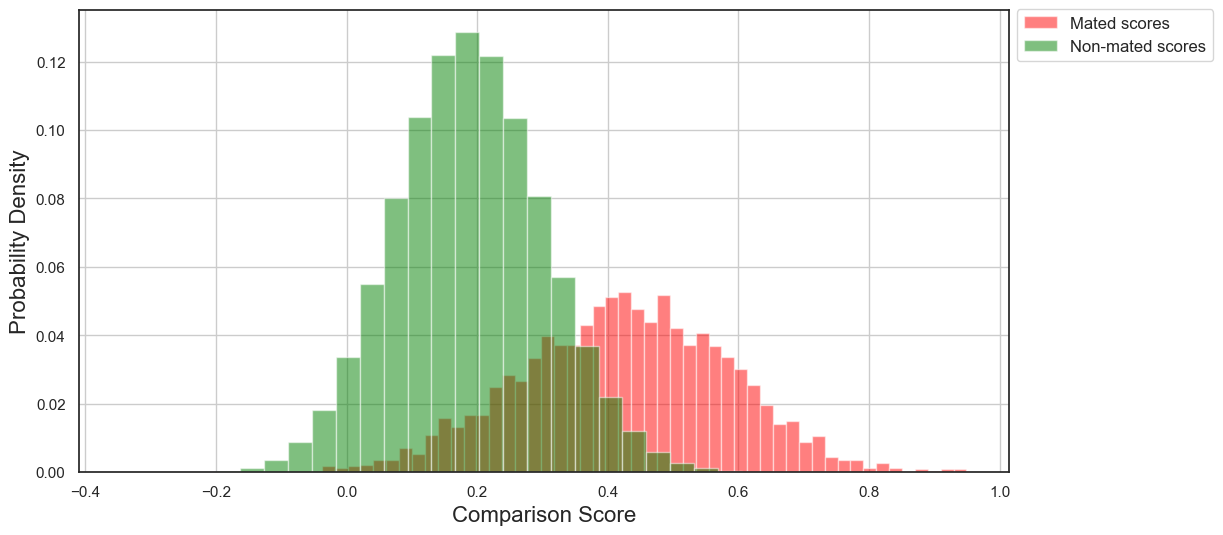

In [11]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True)


### Experiment 1.2: Canonical, non-canonical

In [18]:
df_canonical = pd.read_csv("../../data/OFIQ_results/canonical_children_final.csv", sep=";")

In [19]:
image_names_can, ids_can, num_ids_can, norm_feats_can = load_adaface_vectors(feature_list_children, canonical=True, df_c_can=df_canonical)
# Similarity matrices from adaface - canonical
sim_mat_canonical = np.dot(norm_feats_can, norm_feats_can.T)


In [21]:
random_states = [3]#[1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_adaface_ex1_2 = {}
FNIR_c_list=[]
FNIR_can_list=[]
FPIR_c_list=[]
FPIR_can_list=[]


for random_state_i in random_states:
    
    ### Load children and canonical balanced data ###
    children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
    canonical_names = list(df_canonical.Filename.apply(lambda x: x[:-4]))
    canonical_children_balanced_df_i = children_balanced_df_i[children_balanced_df_i.image_name.isin(canonical_names)]

    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)
    
    
    ### All reference image names, enrolled and non-enrolled image names - canonical ###
    can_mates = canonical_children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_can = can_mates[can_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_can = list(canonical_children_balanced_df_i[canonical_children_balanced_df_i["identity_name"].isin(enrolled_identity_names_can)].image_name)
    non_enrolled_identity_names_can = can_mates[can_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_can = list(canonical_children_balanced_df_i[canonical_children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_can)].image_name)
    all_reference_image_names_can = list(canonical_children_balanced_df_i.image_name)
    

    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_can_all_reference = [image_names_can.index(name) for name in all_reference_image_names_can]
    
    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]
    sim_mat_can_reference_cols = sim_mat_canonical[:, indices_can_all_reference]
    
    # Extract corresponding rows from the numerical ids    
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_can_reference = num_ids_can[indices_can_all_reference]

  
    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids 
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_can_non_enrolled = [image_names_can.index(name) for name in non_enrolled_image_names_can]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_can_non_enrolled = sim_mat_can_reference_cols[indices_can_non_enrolled]

    # Extract corresponding rows from the numerical ids    
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_can_non_enrolled = num_ids_can[indices_can_non_enrolled]
    
    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids 
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_can_enrolled = [image_names_can.index(name) for name in enrolled_image_names_can]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_can_enrolled = sim_mat_a[np.ix_(indices_can_enrolled, indices_can_enrolled)]

    # Extract corresponding rows from the numerical ids    
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_can_enrolled = num_ids_can[indices_can_enrolled]
    

    ### DET THINGS ###
    thold = 0.43
    
    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)    
    FNIR_can, sim_mat_can_enrolled = compute_fnir(sim_mat_can_enrolled, sim_mat_canonical, enrolled_identity_names_can, num_ids_can_enrolled, ids_can, thold=thold)  
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_can = compute_fpir(sim_mat_can_non_enrolled, num_ids_can_non_enrolled, num_ids_can_reference, thold=thold)
    

    FNIR_c_list.append(FNIR_c)
    FNIR_can_list.append(FNIR_can)
    FPIR_c_list.append(FPIR_c)
    FPIR_can_list.append(FPIR_can)
    
        
    sim_mat_dict_all_adaface_ex1_2['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_adaface_ex1_2['sim_mat_can_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_can_enrolled
    sim_mat_dict_all_adaface_ex1_2['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled)
    sim_mat_dict_all_adaface_ex1_2['sim_mat_can_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_can_non_enrolled)
    

    print("done")

# Create a DataFrame from the lists
data_can = {'Iteration': random_states,'FNIR_c': FNIR_c_list, 'FNIR_can': FNIR_can_list, "FPIR_c": FPIR_c_list, "FPIR_can": FPIR_can_list, "Threshold": thold} 
df_can_results = pd.DataFrame(data_can)




done


In [8]:
df_all_results

,Iteration,FNIR_c,FNIR_can,FPIR_c,FPIR_can
0,3,0.228193,0.82768,0.722543,0.702465


In [22]:
sim_mat_dict_all_adaface_ex1_2

{'sim_mat_c_enrolled_iteration_3': array([0.5901362 , 0.5901362 , 0.53564537, ..., 0.6373243 , 0.69479847,
        0.6947131 ], dtype=float32),
 'sim_mat_can_enrolled_iteration_3': array([0.5901362 , 0.5901362 , 0.82328725, ..., 0.8431181 , 0.75716245,
        0.8431181 ], dtype=float32),
 'sim_mat_c_non_enrolled_iteration_3': array([ 0.19151929, -0.15339991,  0.01917464, ...,  0.06998728,
        -0.02960831,  0.06521846], dtype=float32),
 'sim_mat_can_non_enrolled_iteration_3': array([ 0.19151929, -0.15339991,  0.06253705, ...,  0.29800534,
         0.23421547,  0.12478343], dtype=float32)}